In [7]:
import json
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.ltt_utils import create_x_y, run_ltt_cv, run_naive_precision_contorl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
ANNOTATIONS_PATH = "/home/ubuntu/folcon/01_ovary_cuts/roi_annotation_united/all_annotations.json"
PREDICTIONS_PATH = "/home/ubuntu/folcon/04_model_predictions/yolo/results_classif_2.json"
IOU_TH = .3
TARGET_PRECISION = 0.4
THS_CLASSIF = np.arange(.5, 1.5, .05)
THS_DEPTH = np.arange(.3, .8, .05)
THS_OBJ = np.arange(.45, .8, .01)
DELTA = 0.001

In [30]:
len(THS_CLASSIF)

20

In [16]:
with open(ANNOTATIONS_PATH, "r") as f:
    annotations = json.load(f)

with open(PREDICTIONS_PATH, "r") as f:
    predictions = json.load(f)


In [41]:
classif_scores_list = []
for slide_name in predictions:
    for roi in predictions[slide_name]:
        for i in range(len(predictions[slide_name][roi]["scores_classif"])):
            predictions[slide_name][roi]["scores_classif"][i] = 1 - predictions[slide_name][roi]["scores_classif"][i]
        classif_scores_list.extend(predictions[slide_name][roi]["scores_classif"])

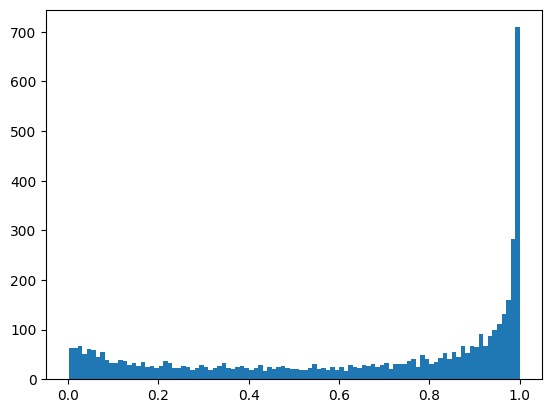

In [42]:
# hist of classif scores in fraction of number of observations
plt.hist(classif_scores_list, bins=100)
plt.show()


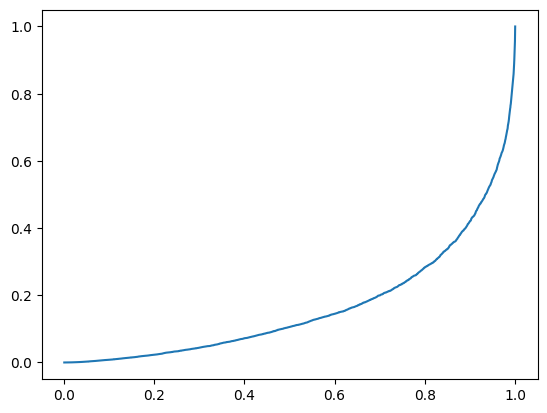

In [19]:
# cumulative distribution of classif scores as percentage of all predictions
classif_scores_list = np.array(classif_scores_list)
classif_scores_list = classif_scores_list.ravel()
classif_scores_list = np.sort(classif_scores_list)
cumulative = np.cumsum(classif_scores_list)
cumulative = cumulative / cumulative[-1]
plt.plot(classif_scores_list, cumulative)
plt.show()


In [31]:
ltt_results_depth = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", other_variable="depths", delta=DELTA, step_fst=None)

ltt_results_depth_fst = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", other_variable="depths", delta=DELTA, step_fst=35)

ltt_results_classical = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", other_variable=None, delta=DELTA)

ltt_results_classif = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_CLASSIF, classes="all", other_variable="scores_classif", delta=DELTA, step_fst=None)

ltt_results_classif_fst = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_CLASSIF, classes="all", other_variable="scores_classif", delta=DELTA, step_fst=20)


naive_method = run_naive_precision_contorl(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, classes="all")

  0%|          | 0/20 [00:00<?, ?it/s]

/home/ubuntu/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/ubuntu/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/ubuntu/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/ubuntu/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/ubuntu/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/ubuntu/follicle-assessment/notebooks/../utils/metrics.py:149: RuntimeWarning: invalid value encountered in divide
  _true_positive(y_pred_th, y_repeat) /
/home/ubuntu/follicle-assessment/noteboo

In [32]:
def get_p_r_ltt(annotations, predictions, ltt_results, name, other_variable):
    global_precisions = []
    global_recalls = []
    global_f1s = []
    for sld_name in ltt_results.keys():
        if len(ltt_results[sld_name]["best_th_depth"]) == 0:
            th_depth = 1
        else:
            th_depth = ltt_results[sld_name]["best_th_depth"][0]
        th_obj = ltt_results[sld_name]["best_th_obj"]
        X, y = create_x_y([sld_name], annotations, predictions, iou_th=IOU_TH, classes="all", other_variable=other_variable)

        X[X[:, :, 1] > th_depth] = 0
        X = X[:, :, 0]
        X_th = X >= th_obj
        precisions = [precision_score(y[i], X_th[i], zero_division=1) for i in range(len(y))]
        recalls = [recall_score(y[i], X_th[i], zero_division=1) for i in range(len(y))]
        f1s = [f1_score(y[i], X_th[i]) for i in range(len(y))]

        global_precisions.append(np.mean(precisions))
        global_recalls.append(np.mean(recalls))
        global_f1s.append(np.mean(f1s))
    
    final_dico = {
        "Metric": ["precisions"] * len(global_precisions) + ["recalls"] * len(global_recalls) + ["f1s"] * len(global_f1s),
        "Value": global_precisions + global_recalls + global_f1s,
        "Method": [name] * (len(global_precisions) + len(global_recalls) + len(global_f1s))
    }

    return final_dico

In [33]:
dico_ltt_detph = get_p_r_ltt(annotations, predictions, ltt_results_depth, "LTT with depth", "depths")
dico_ltt_classical = get_p_r_ltt(annotations, predictions, ltt_results_classical, "LTT classical", "depths")
ltt_results_naive = get_p_r_ltt(annotations, predictions, naive_method, "Naive method", "depths")
dico_ltt_classif = get_p_r_ltt(annotations, predictions, ltt_results_classif, "LTT with classif", "scores_classif")
dico_ltt_classif_fst = get_p_r_ltt(annotations, predictions, ltt_results_classif_fst, "LTT with classif fst", "scores_classif")
dico_ltt_depth_fst = get_p_r_ltt(annotations, predictions, ltt_results_depth_fst, "LTT with depth fst", "depths")

In [34]:
concat_dico = pd.concat([
    pd.DataFrame(dico_ltt_detph),
    pd.DataFrame(dico_ltt_depth_fst),
    pd.DataFrame(dico_ltt_classif),
    pd.DataFrame(dico_ltt_classif_fst),
    pd.DataFrame(dico_ltt_classical),
    pd.DataFrame(ltt_results_naive)
])

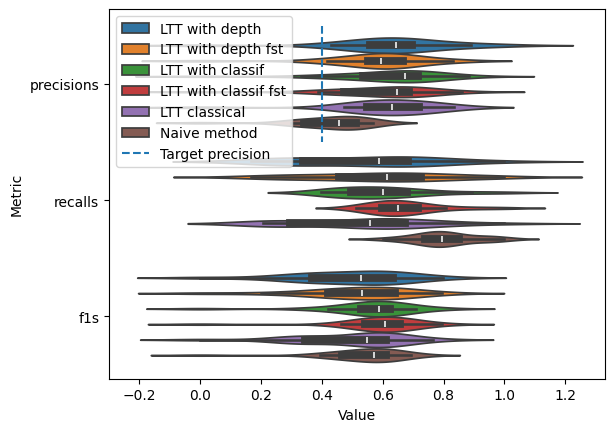

In [35]:
sns.violinplot(data=concat_dico,  x="Value", y="Metric", hue="Method", split=False, orient="h")
plt.vlines(TARGET_PRECISION, -0.5, .5, linestyles="dashed", label="Target precision")
plt.legend()


In [36]:
concat_dico[concat_dico["Metric"] == "precisions"].groupby("Method")["Value"].mean()

Method
LTT classical           0.608092
LTT with classif        0.607326
LTT with classif fst    0.587193
LTT with depth          0.625349
LTT with depth fst      0.576288
Naive method            0.426601
Name: Value, dtype: float64

In [37]:
concat_dico[concat_dico["Metric"] == "recalls"].groupby("Method")["Value"].mean()

Method
LTT classical           0.533929
LTT with classif        0.600841
LTT with classif fst    0.673934
LTT with depth          0.541427
LTT with depth fst      0.589085
Naive method            0.803206
Name: Value, dtype: float64

In [38]:
concat_dico[concat_dico["Metric"] == "f1s"].groupby("Method")["Value"].mean()

Method
LTT classical           0.490657
LTT with classif        0.551127
LTT with classif fst    0.581288
LTT with depth          0.488306
LTT with depth fst      0.506399
Naive method            0.528291
Name: Value, dtype: float64

In [34]:
ltt_results_depth

{'4C_e': {'best_th_obj': [0.6400000000000001], 'best_th_depth': [0.35]},
 '4C_c': {'best_th_obj': [0.6300000000000001],
  'best_th_depth': [0.39999999999999997]},
 '4A_g': {'best_th_obj': [0.6200000000000001],
  'best_th_depth': [0.39999999999999997]},
 '4A_b': {'best_th_obj': [0.6300000000000001],
  'best_th_depth': [0.39999999999999997]},
 '4A_a': {'best_th_obj': [0.6300000000000001],
  'best_th_depth': [0.39999999999999997]},
 '3M09': {'best_th_obj': [0.6300000000000001], 'best_th_depth': [0.35]},
 '3A_f': {'best_th_obj': [0.6200000000000001],
  'best_th_depth': [0.39999999999999997]},
 '3A_g': {'best_th_obj': [0.6200000000000001],
  'best_th_depth': [0.7499999999999999]},
 '2M18': {'best_th_obj': [0.6300000000000001],
  'best_th_depth': [0.39999999999999997]},
 '2M11': {'best_th_obj': [0.6300000000000001],
  'best_th_depth': [0.39999999999999997]},
 '2M08': {'best_th_obj': [0.6200000000000001],
  'best_th_depth': [0.39999999999999997]},
 '2M07': {'best_th_obj': [0.6200000000000001]